# Implementations of rhat, or potential scale reduction fuctor, or gelman-diag coef.

## The 'potential scale reduction factor'

> Gelman and Rubin (1992) propose a general approach to monitoring convergence of MCMC output in which $ m>1 $ parallel chains are run with starting values that are overdispersed relative to the posterior distribution. Convergence is diagnosed when the chains have 'forgotten' their initial values, and the output from all chains is indistinguishable. 

https://cran.r-project.org/web/packages/coda/coda.pdf

## Preparements

### Pythonic setup

In [1]:
import numpy as np
np.random.seed(0)

import scipy as sp

import pandas as pd
pd.set_option('display.width', 200)

% matplotlib inline
import seaborn as sns
from seaborn import plt
plt.rcParams['figure.figsize'] = (10, 5)

### Test Data

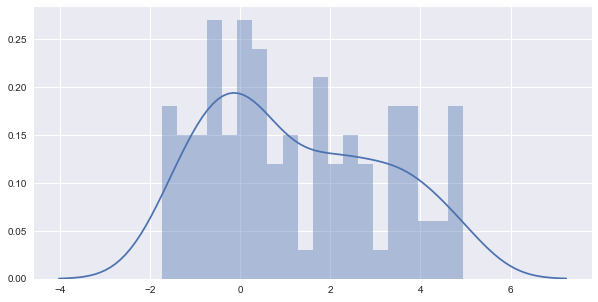

In [2]:
np.random.normal(0, 1, 40)
Y = np.concatenate((np.random.normal(0, 1, 60), np.random.normal(3, 1, 40)))
p = sns.distplot(Y, bins=20)

### Sampling

In [3]:
def sample_mu(y, N, s):
    mean = np.sum(y) / N
    variance = s * s / N
    return np.random.normal(mean, np.sqrt(variance))

def sample_s(y, N, mu):
    alpha = N / 2 + 1
    residuals = y - mu
    beta = np.sum(residuals * residuals) / 2
    tau = np.random.gamma(alpha, 1 / beta)
    return 1 / np.sqrt(tau)

def gibbs(y, iters, chains, inits):
    N = len(y)
    
    trace = np.zeros((iters*chains, 4)) ## trace to store values of mu, s
    log_likelihoods = np.zeros((iters*chains, N))
    
    for c in range(chains):
        
        mu = inits[c]["mu"]
        s = inits[c]["s"]
        for i in range(iters):
            mu = sample_mu(y, N, s)
            s = sample_s(y, N, mu)
            trace[c*iters + i, :] = np.array((i, mu, s, c))

            norm = sp.stats.norm(mu, s)
            log_likelihoods[c*iters + i, :] = np.array([np.log(norm.pdf(x)) for x in y])
    
    trace = pd.DataFrame(trace)
    trace.columns = ["Iteration", "mu", "s", "Chain"]
    
    log_likelihoods = pd.DataFrame(log_likelihoods)
    
    return trace, log_likelihoods

init = lambda: {"mu": np.random.uniform(-100, 100), "s": np.random.uniform(0, 100)}
iters = 1000
chains = 3
trace, _ = gibbs(Y, iters, chains, [init() for x in range(chains)])

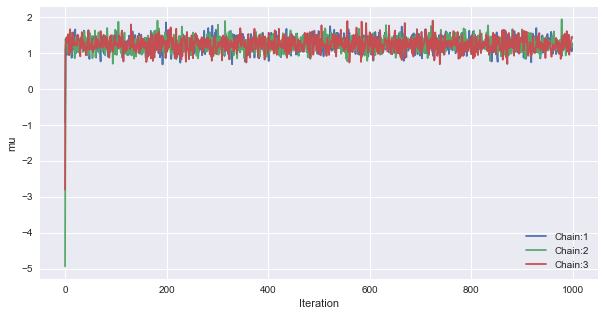

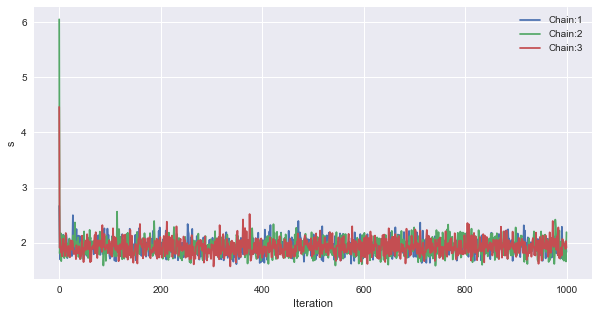

In [39]:
for i, x in trace.groupby("Chain"):
    ax = plt.plot(x["Iteration"], x["mu"], label="Chain:{:.0f}".format(i+1))

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("mu")
plt.show()

for i, x in trace.groupby("Chain"):
    ax = plt.plot(x["Iteration"], x["s"], label="Chain:{:.0f}".format(i+1))

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("s")
plt.show()

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))
df = df.cumsum()
plt.figure(); df.plot();

## Implementations

### coda

In [ ]:
from subprocess import Popen, PIPE

R = Popen(["R", "--vanilla", "--silent"], stdin=PIPE, stdout=PIPE)

R.stdin.write(b'''
library(coda)
gelman.diag
''')
out, err = R.communicate()
print(out.decode("utf8"))

## References

[Inference from Iterative Simulation Using Multiple Sequences](https://projecteuclid.org/euclid.ss/1177011136)